In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

Read in the locations of the parts that are labeled on each image, and join them with the address of the corresponding images. This is to be able to train a classifier to distinguish between each `part_id` by looking at that part in the image.

In [6]:
# read in part locations
part_locs = pd.read_csv('CUB_200_2011/CUB_200_2011/parts/part_locs.txt', sep=' ', header=None)
part_locs.columns = ['image_id', 'part_id', 'x', 'y', 'visible']

# read in image ids and their addresses
im_id_addrs = pd.read_csv('CUB_200_2011/CUB_200_2011/images.txt', sep=' ', header=None)
im_id_addrs.columns = ['image_id', 'image_addr']

# join part locations and image id dataframes in order to get (part, image address) mappings
im_addr_parts = pd.merge(part_locs, im_id_addrs, on='image_id')

# read in bounding boxes per image id
im_bbs = pd.read_csv('CUB_200_2011/CUB_200_2011/bounding_boxes.txt', sep=' ', header=None)
im_bbs.columns = ['image_id', 'bb_x', 'bb_y', 'bb_w', 'bb_h']

im_addr_parts = pd.merge(im_addr_parts, im_bbs, on='image_id')

im_classes = pd.read_csv('CUB_200_2011/CUB_200_2011/image_class_labels.txt', sep=' ', header=None)
im_classes.columns = ['image_id', 'class_id']

im_addr_parts = pd.merge(im_addr_parts, im_classes, on='image_id')

# read in part labels manually because parts can be two words
part_labels = []
with open('CUB_200_2011/CUB_200_2011/parts/parts.txt') as part_labels_file:
    for row in part_labels_file:
        sep = row.find(' ')
        part_id, part_name = row[:sep], row[sep + 1:-1]
        part_labels.append({'part_id': int(part_id), 'part_name': part_name})
part_labels = pd.DataFrame.from_dict(part_labels)

# join (part, image addresses) with part labels to make part_id's comprehensible
im_addr_parts = pd.merge(im_addr_parts, part_labels, on='part_id')
# print(im_addr_parts.head(30))

In [7]:
# display the parts on the images
fig = plt.figure(figsize=(30, 30))
DISPLAY = False
NUM_CLASSES = 15 # limit classes trained

import matplotlib.patches as patches
from skimage import io
from skimage import transform
from collections import defaultdict

# GENERATE THE TRAINING DATA

PARTS = defaultdict(list)
# first level key = class_id. second level key = part_id

class_ids = set()

im_addr_parts = im_addr_parts.sort_values('class_id')
for index, row in im_addr_parts.iterrows():
    im_id, part_id, x, y, visible, im_addr, bb_x, bb_y, bb_w, bb_h, class_id, part_name = row
    
    if class_id not in class_ids:
        if len(class_ids) >= NUM_CLASSES:
            break
        class_ids.add(class_id)
        print('Operating on class', class_id)
    
    if not visible:
        continue
    
    img = io.imread('CUB_200_2011/CUB_200_2011/images/' + im_addr, as_grey=True)
    
    bb_x, bb_y, bb_w, bb_h = int()
    fg_img = extract_foreground(img[bb_x:bb_x + bb_w, bb_y:bb_y + bb_h])
    plt.imshow(img)
    plt.show()
    
#     for scale in range(5, 21, 5):
#         x, y = int(x), int(y)
#         part_crop = img[x - scale:x + scale, y - scale:y + scale]
#         if 0 in part_crop.shape:
#             continue
#         resized = transform.resize(part_crop, (20, 20))
#         PARTS[class_id][part_id].append(resized)
    
#     if DISPLAY:
#         ax = fig.add_subplot(5, 5, counter)
#         ax.imshow(img)
#         bb = patches.Rectangle((bb_x, bb_y), bb_w, bb_h, fill=False)
#         ax.add_patch(bb)
#         ax.plot(x, y, '+', linewidth=100, color='red')

#     for scale in range(5, 40, 5):
#         filt = patches.Rectangle((x - scale, y - scale), scale * 2, scale * 2, fill=False)
#         if DISPLAY:
#             ax.add_patch(filt)

# for class_id in PARTS.keys():
#     part_dict = dict(PARTS[class_id])
#     temp_parts = {}
#     for part_id, parts in part_dict.items():
#         temp_parts[part_id] = np.array(parts)
#     PARTS[class_id] = temp_parts

# import pickle
# pickle.dump(dict(PARTS), open('training_patches', 'wb'))

# plt.show()

Operating on class 1


TypeError: slice indices must be integers or None or have an __index__ method

In [ ]:
import pickle
import numpy as np
PARTS = pickle.load(open('training_patches', 'rb'))
# PARTS: {class_id: {part_id: [img, ...]}...}

# reshape the parts into something that tensorflow will process

imgs_array = np.empty(shape=(0, 20, 20))
labels_array = np.zeros(shape=(0))
for class_id, parts in PARTS.items():
    for part_id, part_ary in parts.items():
        imgs_array = np.concatenate((imgs_array, part_ary), axis=0)
        # create labels array of same length as part_ary (# of images for that part)
        part_labels = [part_id] * part_ary.shape[0] # [15 * (class_id - 1) + part_id] * part_ary.shape[0]
        labels_array = np.concatenate((labels_array, part_labels), axis=0)

In [ ]:
import tensorflow as tf

inputs_ph = tf.placeholder(tf.float32, (None, 20, 20, 1), name='inputs')

labels_ph = tf.placeholder(tf.int64, (None), name='labels')

num_classes = 15 # * 15

h = tf.contrib.layers.conv2d(inputs=inputs_ph, num_outputs=20, kernel_size=[4, 4], stride=2, padding='same', activation_fn=tf.nn.relu)
h = tf.contrib.layers.conv2d(inputs=h, num_outputs=70, kernel_size=[4, 4], stride=2, padding='same', activation_fn=tf.nn.relu)
h = tf.contrib.layers.conv2d(inputs=h, num_outputs=120, kernel_size=[4, 4], stride=2, padding='same', activation_fn=tf.nn.relu)
h = tf.contrib.layers.conv2d(inputs=h, num_outputs=170, kernel_size=[4, 4], stride=2, padding='same', activation_fn=tf.nn.relu)
h = tf.contrib.layers.conv2d(inputs=h, num_outputs=num_classes + 1, kernel_size=[4, 4], stride=2, padding='same', activation_fn=None)

h = tf.contrib.layers.flatten(h)

print(h)

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=labels_ph))
optimizer = tf.train.AdamOptimizer(0.0005, 0.9, 0.999)
opt = optimizer.minimize(loss)
# correct = tf.equal(tf.argmax())

In [ ]:
BS = 80

sess = tf.Session()
sess.run(tf.global_variables_initializer())

input_imgs_ary = np.expand_dims(imgs_array, axis=3).astype(np.float32)
print(input_imgs_ary.dtype)

labels_array = labels_array.astype(np.int64)
for epoch in range(30):
    np.random.seed(epoch)
    np.random.shuffle(input_imgs_ary)
    np.random.seed(epoch)
    np.random.shuffle(labels_array)
    loss_vals = []
    for i in range(0, input_imgs_ary.shape[0]-BS+1, BS):
        # Train a single batch
        batch_images, batch_labels = input_imgs_ary[i:i+BS], labels_array[i:i+BS]
        loss_val, _ = sess.run([loss, opt], feed_dict={inputs_ph: batch_images, labels_ph: batch_labels})
#         accuracy_vals.append(accuracy_val)
        loss_vals.append(loss_val)
    print(np.mean(loss_vals))
    
    # no validation accuracy yet.
#     print('[%3d] Accuracy: %0.3f  \t  Loss: %0.3f' %(epoch, np.mean(accuracy_vals)))

Read in the attribute labels on each image.

In [ ]:
image_labels_raw = pd.read_csv('CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', \
                               sep=' ', header=None, error_bad_lines=False)
image_labels_raw.columns = ['image_id', 'attribute_id', 'is_present', 'certainty_id', 'time']
print(image_labels_raw.head(5))
num_attributes = image_labels_raw.attribute_id.max()
num_images = image_labels_raw.image_id.max()

Create an embedding for `image_labels_raw`. Each image can have several of many attributes, but this is sparse. For example, an image of a bird can have "pointy beak", "blue belly", but not "white tufts". Each of these labels is associated with an integer id, `attribute_id` column as shown in the output of the previous cell. This embedding's rows represent the `image_id`, and the columns are `0` if the `attribute_id` is not present for that image, and `1` if it is present.

The cell below runs for 3.67M rows, which takes awhile to run. Then, it's saved to disk so that it can be loaded quickly.

In [ ]:
image_labels = np.zeros((num_images, num_attributes))
for idx, row in image_labels_raw.iterrows():
    im_id = int(row['image_id']) - 1
    attr_id = int(row['attribute_id']) - 1
    if row['is_present'] == 1.0:
        image_labels[im_id][attr_id] = 1
    if idx % 50000 == 0:
        print(idx, end=' ')
np.save('im_label_embedding.npy', image_labels)

In [ ]:
image_labels = np.load('im_label_embedding.npy')

In [ ]:
print(image_labels.shape)

In [ ]:
from skimage.feature import hog
from skimage import data, exposure

In [ ]:
camera = data.camera()

In [ ]:
fd, hog_image = hog(camera, orientations=8, pixels_per_cell=(8, 8), \
                   cells_per_block=(1,1), visualise=True)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

import matplotlib.pyplot as plt
print(hog_image_rescaled.shape)
plt.imshow(hog_image_rescaled)
plt.show()

In [ ]:
# read images as input. Filter only for images from 10 classes.
# HOG detector on entire image
# find points from part centers
# Bounding box around part centers (size tbd, energy maximization) to create filters
# inspiration from DPM paper on size of bounding box.
# train each label to be average of bounding box.

# train on 90% of images, holdout on 10%.

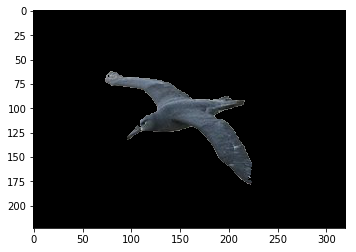

In [4]:
def extract_foreground(im_path, do_show = True, extract_bb = False):
    # https://docs.opencv.org/trunk/d8/d83/tutorial_py_grabcut.html
    
    import cv2
    camera = cv2.imread(im_path)

    w, h = camera.shape[:2]
    mask = np.zeros([w, h], np.uint8)
    bgdModel = np.zeros((1,65), np.float64)
    fgdModel = np.zeros((1,65), np.float64)
    rect = (1, 1, w, h)
    cv2.grabCut(camera,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    segmented = camera*mask2[:,:,np.newaxis]
    
    # Return only the bounding box of the foreground
    
    if not extract_bb:
        return segmented
    else:
        # Get contours (edge image) of the foreground-separated image
        # https://docs.opencv.org/3.3.1/dd/d49/tutorial_py_contour_features.html
        segmented_edges = cv2.Canny(segmented, 0, 255)
        _,thresh = cv2.threshold(segmented_edges,127,255,0)
        _,contours,_ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # find bounding box around the bird (union of all contours points)
        min_x, min_y = [9999999999] * 2
        max_x, max_y = [0] * 2
        for contour in contours:
            for coord in contour:
                coord = coord[0]
                min_x = min(min_x, coord[0])
                max_x = max(max_x, coord[0])
                min_y = min(min_y, coord[1])
                max_y = max(max_y, coord[1])

        cropped = segmented[min_y:max_y, min_x:max_x]
        if do_show:
            plt.imshow(cropped),plt.colorbar(),plt.show()
        return cropped

img = extract_foreground('./CUB_200_2011/CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg')

In [ ]:
# stopping point.
# next: write code to extract pre-defined parts from images
# the parts should be bounded by maximum energy.
# In order to train CNN to classify parts. There are 135 distinct labels.

# possible points of comparison: using Andrew Krause's work with randomly
# sampling POI in image.
# OR using HOG descriptor and dimensionality reduction on unsupervised method
# of finding distinct points.

# show that there is room to improve
# can we bound an improvement accuracy